<a href="https://colab.research.google.com/github/whrui720/SMA-PairsTrade/blob/main/HarryP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_datareader
from pandas_datareader import data as pdr

In [ ]:
start = dt.date(2020, 1, 1)
end = dt.date(2024, 1, 1)

tickers = ['GOOGL', 'NVDA', 'TSLA', 'META', 'AMZN', 'NFLX', 'INTC', 'CRM', 'SHOP', 'TWLO', 'CSCO']

df = yf.download(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  11 of 11 completed


Ticker,AMZN,CRM,CSCO,GOOGL,INTC,META,NFLX,NVDA,SHOP,TSLA,TWLO
Date,,,,,,,,,,,
2023-12-22 00:00:00+00:00,153.419998,266.339996,50.090000,141.490005,48.000000,353.390015,486.760010,48.830002,76.830002,252.539993,76.279999
2023-12-26 00:00:00+00:00,153.410004,266.220001,50.279999,141.520004,50.500000,354.829987,491.190002,49.278999,78.209999,256.609985,76.910004
2023-12-27 00:00:00+00:00,153.339996,266.720001,50.439999,140.369995,50.759998,357.829987,491.790009,49.417000,78.339996,261.440002,77.389999
2023-12-28 00:00:00+00:00,153.380005,265.579987,50.480000,140.229996,50.389999,358.320007,490.510010,49.521999,79.110001,253.179993,77.169998
2023-12-29 00:00:00+00:00,151.940002,263.140015,50.520000,139.690002,50.250000,353.959991,486.880005,49.521999,77.900002,248.479996,75.870003


In [ ]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

[('CRM', 'META'), ('CSCO', 'GOOGL')]


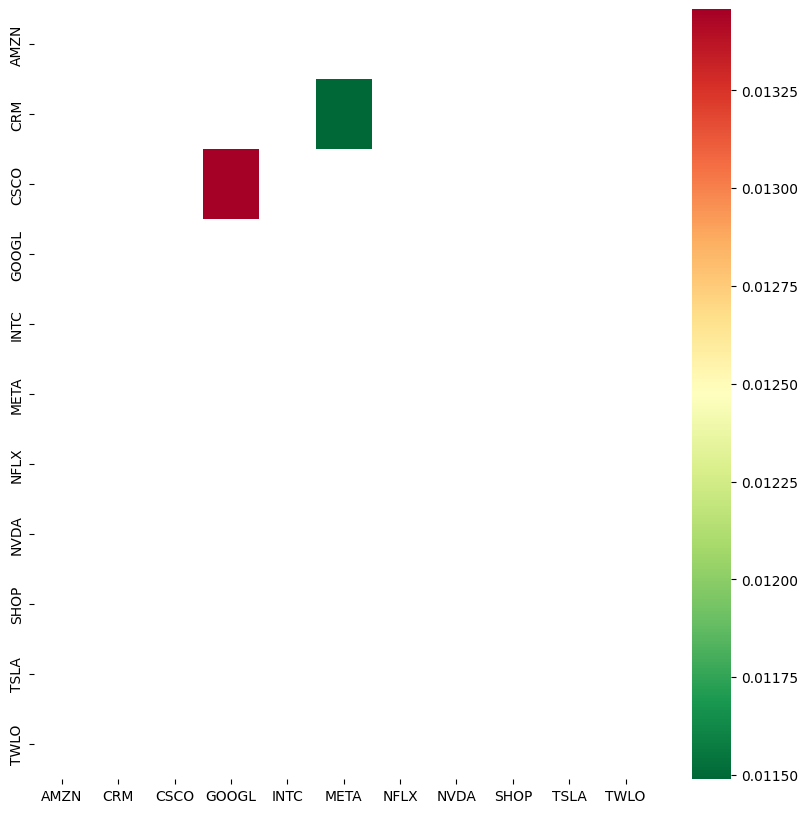

In [ ]:
scores, pvalues, pairs = find_cointegrated_pairs(df)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r'
                , mask = (pvalues >= 0.05)
                )
print(pairs)

In [ ]:
S1 = df['CRM']
S2 = df['META']

score, pvalue, _ = coint(S1, S2)
pvalue

0.011489248526614074

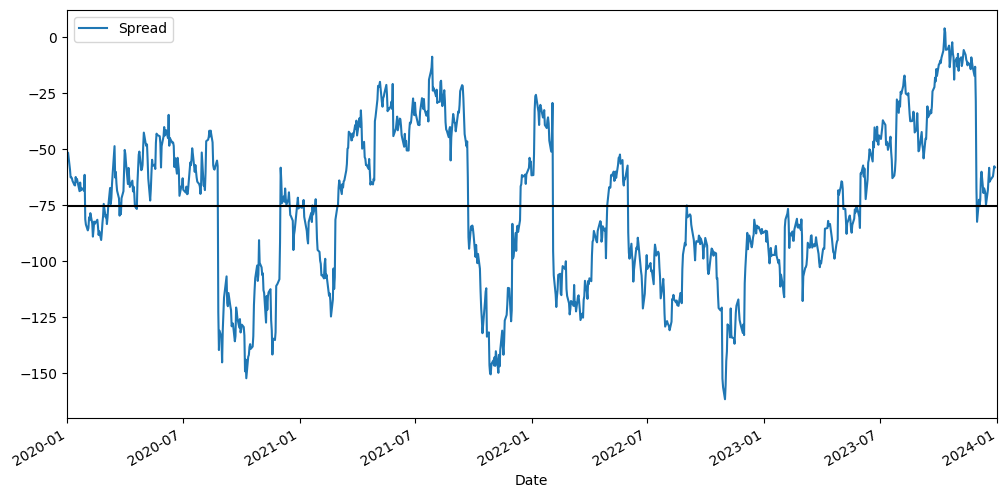

In [ ]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['CRM']
b = results.params['CRM']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2020-01-01', '2024-01-01')
plt.legend(['Spread']);

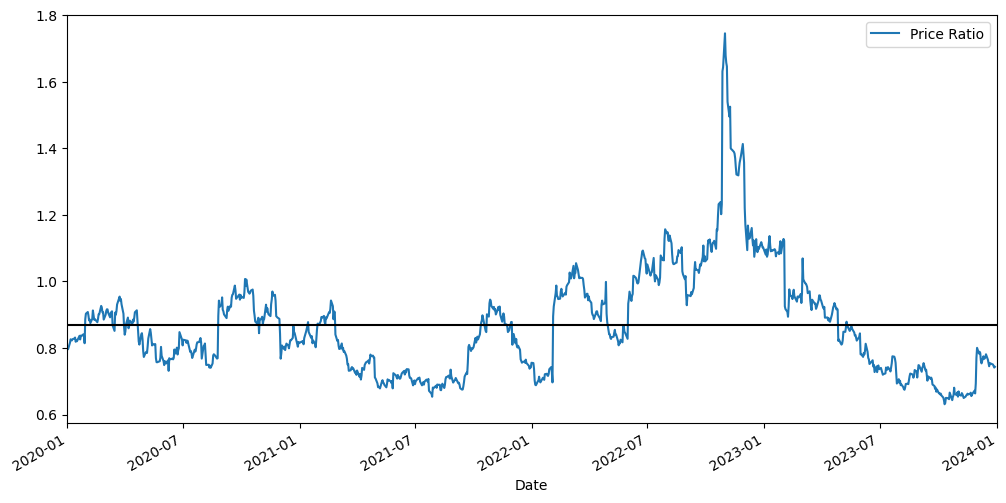

In [ ]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2020-01-01', '2024-01-01')
plt.legend(['Price Ratio']);

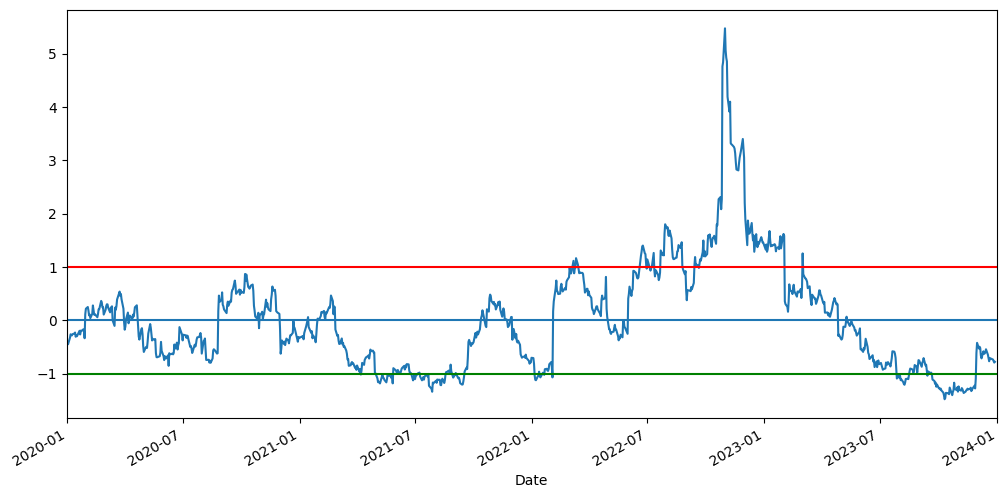

In [ ]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2020-01-01', '2024-01-01')
plt.show()

In [ ]:
ratios = df['CRM'] / df['META']
print(len(ratios) * .70 )

704.1999999999999


In [ ]:
train = ratios[:704]
test = ratios[704:]

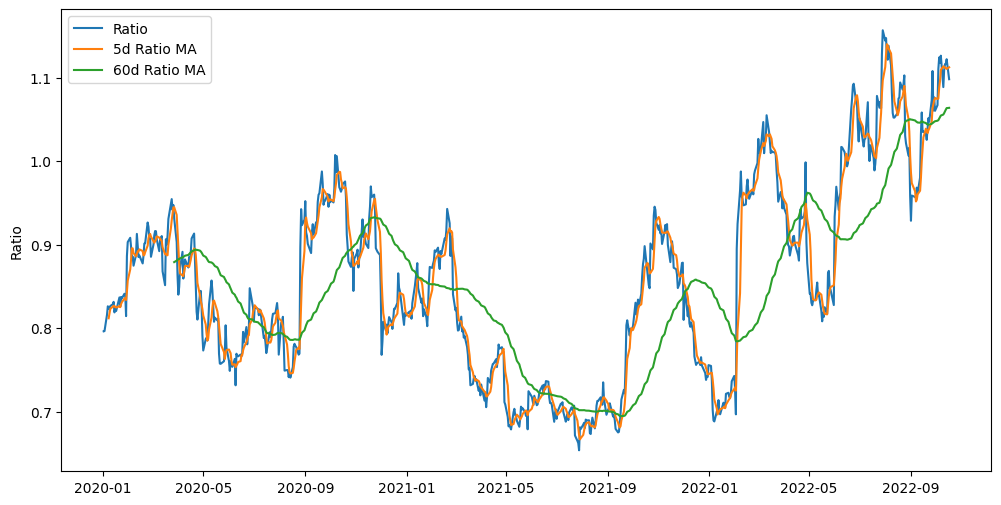

In [ ]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

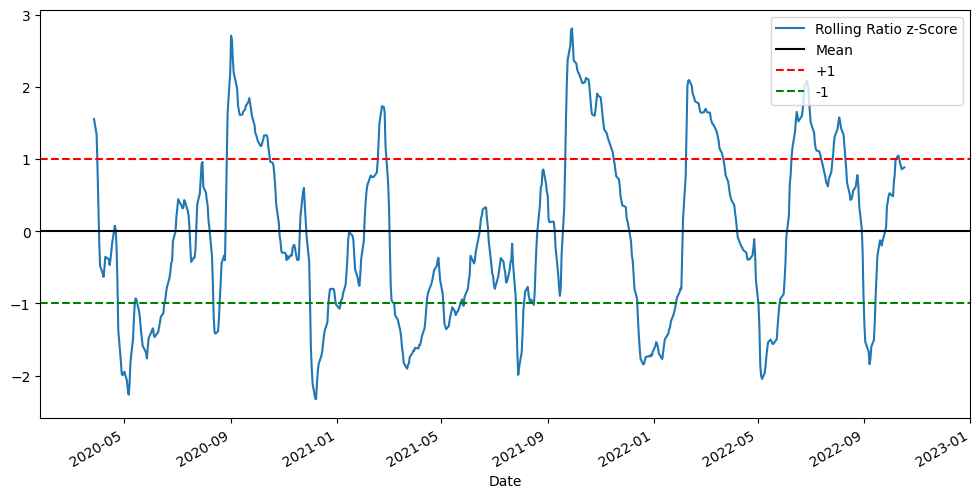

In [ ]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2020-01-25', '2023-01-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

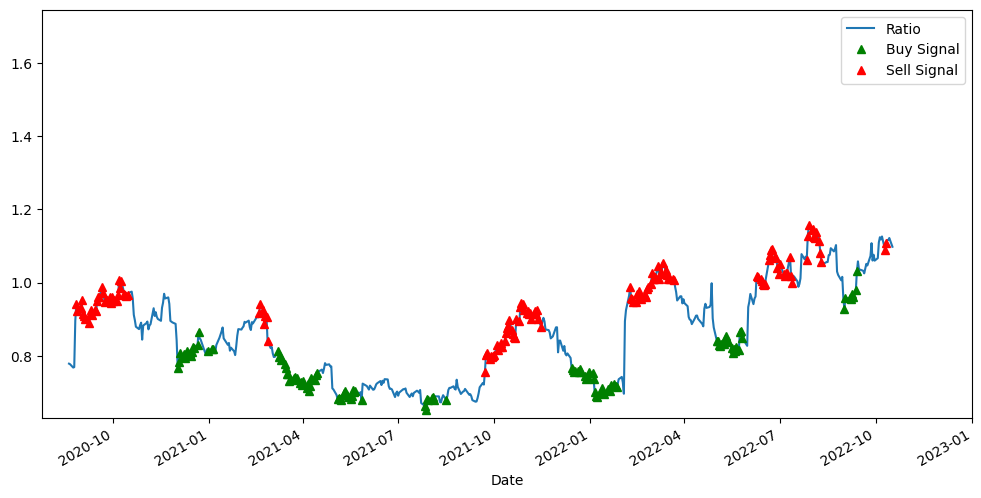

In [ ]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2020-07-25', '2023-01-01')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

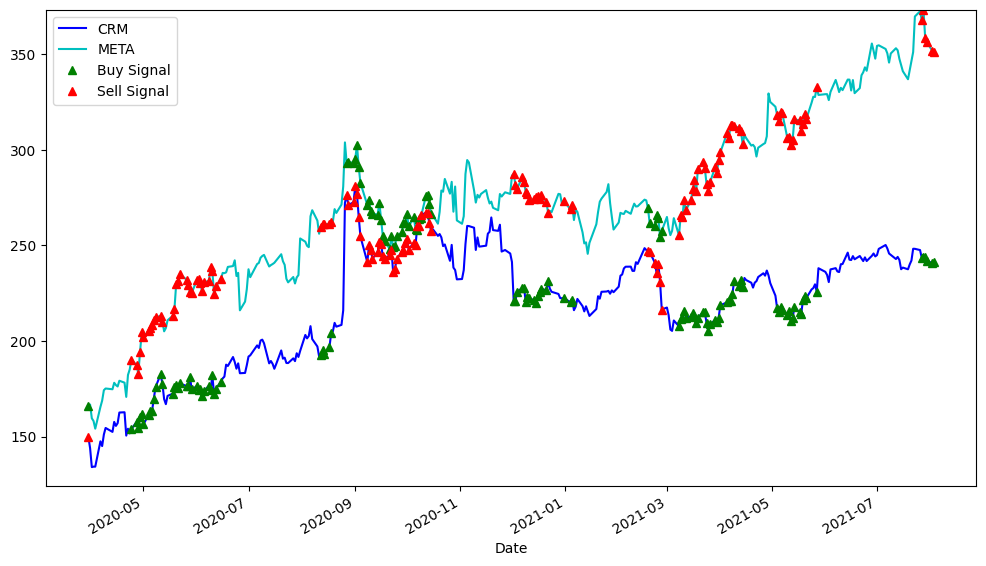

In [ ]:
plt.figure(figsize=(12,7))
S1 = df['CRM'].iloc[:400]
S2 = df['META'].iloc[:400]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))


plt.legend(['CRM', 'META', 'Buy Signal', 'Sell Signal'])
plt.show()

In [41]:
def trade(S1, S2, window1, window2):

    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std

    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
          #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
          #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))


    return money

In [43]:
trade(df['CRM'].iloc[400:], df['META'].iloc[400:], 60, 5)

<ipython-input-41-33ca788cf0b0>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] < -1:
<ipython-input-41-33ca788cf0b0>:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] > 1:
<ipython-input-41-33ca788cf0b0>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif abs(zscore[i]) < 0.75:
<ipython-input-41-33ca788cf0b0>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future

-2399.965126216209